In [68]:
import os
import pandas as pd

def read_text_file(base_folder, timestamp, file_name):
    """
    Reads a text file from a specified timestamp folder using pandas, 
    handling mixed delimiters (commas and whitespace) properly, 
    and dynamically naming columns.
    """
    folder_path = os.path.join(base_folder, timestamp)
    file_path = os.path.join(folder_path, file_name)
    
    if not os.path.exists(file_path):
        print(f"Error: The file '{file_name}' does not exist in the folder '{folder_path}'.")
        return None

    data = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            processed_parts = parts[:2] + parts[2].split()
            data.append(processed_parts)

    df = pd.DataFrame(data)

    num_columns = df.shape[1]
    
    # Define the first two column names
    column_names = ["Span", "Beam"]
    
    # If there's at least 3 columns, assign "Co-ordinate" to the third column
    if num_columns > 2:
        column_names.append("Co-ordinate")
    
    remaining_columns = [f"Column_{i+1}" for i in range(num_columns - len(column_names))]

    df.columns = column_names + remaining_columns

    return df

# Enter time stemp and loop name
base_folder = '../0_GAB'  
timestamp = '20141129120000'  # Time stamp
file = 'N-B_Far_Comp.txt'  # Name of loop
df = read_text_file(base_folder, timestamp, file)

print(df)



    Span Beam Co-ordinate Column_1 Column_2 Column_3 Column_4 Column_5
0    N13    B       12.64      110        0        0    -11.5  1312.64
1    N13    B       12.54      116        0        0    -11.5  1312.54
2    N13    B       12.44      121        0        0    -11.5  1312.44
3    N13    B       12.34      119        0        0    -11.5  1312.34
4    N13    B       12.24      113        0        0    -11.3  1312.24
..   ...  ...         ...      ...      ...      ...      ...      ...
626  N10    B        1.32       13        0        0     -5.8  1001.32
627  N10    B        1.21       11        0        0     -5.8  1001.21
628  N10    B        1.11        7        0        0     -5.8  1001.11
629  N10    B        1.01        4        0        0     -5.8  1001.01
630  N10    B        0.91        2        0        0     -5.8  1000.91

[631 rows x 8 columns]


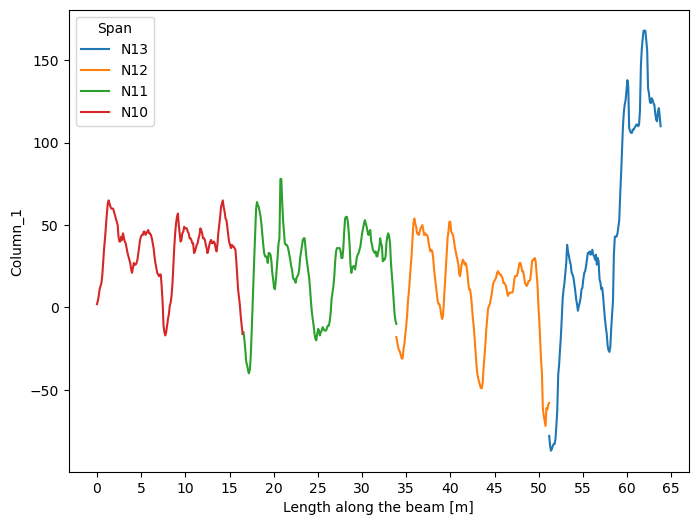

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df["Co-ordinate"] = pd.to_numeric(df["Co-ordinate"], errors="coerce")
df["Column_1"] = pd.to_numeric(df["Column_1"], errors="coerce")

# Define which columns to use for plotting, check the excel for what column
y_col = "Column_1"   # Y-axis 

x_col = "Co-ordinate" 
df["Adjusted_Coordinate"] = df[x_col]  

df["Span_Number"] = df["Span"].str.extract(r'(\d+)').astype(float)
span_order = df.groupby("Span")["Span_Number"].first().sort_values().index.tolist()

offset = 0

for span in span_order:
    span_mask = df["Span"] == span
    if span_mask.any():
        min_coord = df.loc[span_mask, x_col].min()  
        df.loc[span_mask, "Adjusted_Coordinate"] += offset - min_coord
        offset = df.loc[span_mask, "Adjusted_Coordinate"].max()  

plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x="Adjusted_Coordinate", y=y_col, hue="Span", linestyle="-") #add markers: marker="o",

plt.xlabel('Length along the beam [m]')  
plt.ylabel(y_col)  
tick_spacing = 5  # Adjust this value to control the frequency of ticks
x_min, x_max = df["Adjusted_Coordinate"].min(), df["Adjusted_Coordinate"].max()
plt.xticks(np.arange(x_min, x_max + tick_spacing, tick_spacing)) 
plt.yticks()  
plt.show()




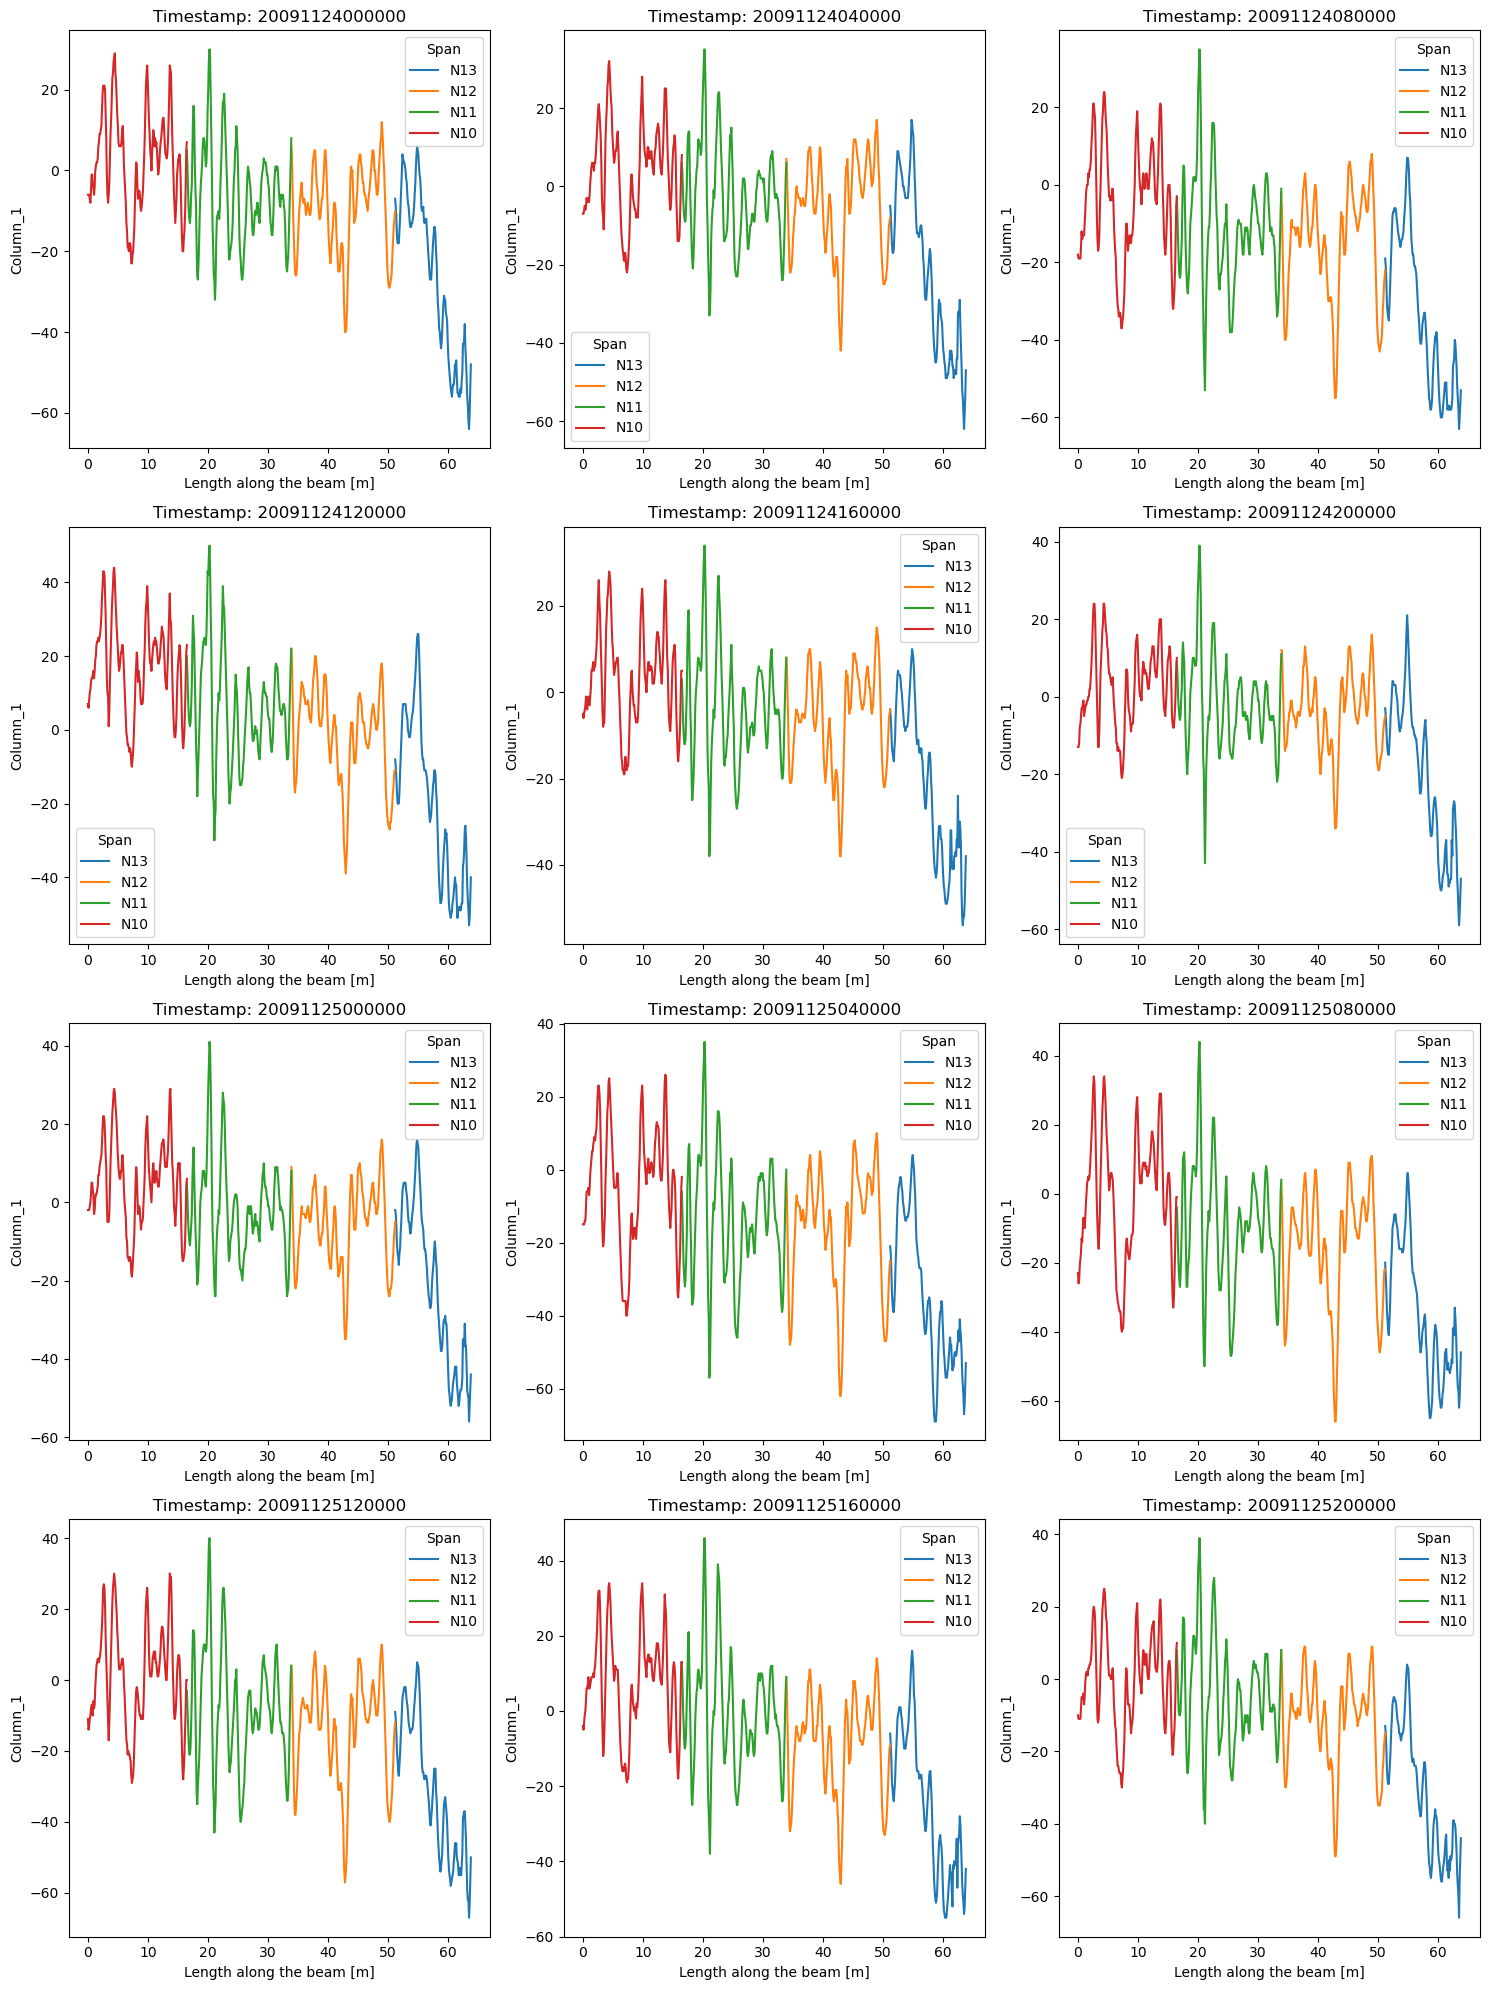

In [83]:
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

def load_existing_folders(base_folder):
    """Return a list of folder names inside base_folder."""
    try:
        return sorted(os.listdir(base_folder))  # Sort for consistency
    except FileNotFoundError:
        raise FileNotFoundError(f"Base folder '{base_folder}' not found.")
    
def plot_multiple_spans(timestamps, base_folder, file_name, n):    

    # if len(timestamps) < n:
    #     raise ValueError(f"Only {len(timestamps)} timestamps available, but {n} were requested.")

    selected_timestamps = random.sample(timestamps, n)
    selected_timestamps = sorted(selected_timestamps)

    cols = 3
    rows = math.ceil(n / cols)  # Calculate rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Adjust figure size

    # Flatten axes array to make indexing easier
    axes = axes.flatten()

    for i, timestamp in enumerate(selected_timestamps):
        df = read_text_file(base_folder, timestamp, file_name)
        if df is None:
            continue  # Skip if file is missing

        df["Co-ordinate"] = pd.to_numeric(df["Co-ordinate"], errors="coerce")
        df["Column_1"] = pd.to_numeric(df["Column_1"], errors="coerce")

        # Define which columns to use for plotting, check the excel for what column
        y_col = "Column_1"   # Y-axis 

        x_col = "Co-ordinate" 
        df["Adjusted_Coordinate"] = df[x_col]  

        df["Span_Number"] = df["Span"].str.extract(r'(\d+)').astype(float)
        span_order = df.groupby("Span")["Span_Number"].first().sort_values().index.tolist()

        offset = 0

        for span in span_order:
            span_mask = df["Span"] == span
            if span_mask.any():
                min_coord = df.loc[span_mask, "Co-ordinate"].min()
                df.loc[span_mask, "Adjusted_Coordinate"] += offset - min_coord
                offset = df.loc[span_mask, "Adjusted_Coordinate"].max()

        # Plot in subplot
        sns.lineplot(data=df, x="Adjusted_Coordinate", y="Column_1", hue="Span", linestyle="-", ax=axes[i])
        axes[i].set_xlabel('Length along the beam [m]')
        axes[i].set_ylabel("Column_1")
        axes[i].set_title(f"Timestamp: {timestamp}")

    plt.tight_layout()
    plt.show()

base_folder = '../0_GAB'
file_name = 'N-B_Far_Comp.txt'  # The file inside each timestamp folder
n = 12  # Number of timestamps to randomly select
# timestamps = load_existing_folders(base_folder)
timestamps = ['20091124000000', '20091124040000', '20091124080000', '20091124120000', '20091124160000', '20091124200000', '20091125000000', '20091125040000', '20091125080000', '20091125120000', '20091125160000', '20091125200000']
plot_multiple_spans(timestamps, base_folder, file_name, n)
